# Backtest Evaluation – Baseline Model with Holding Period + Trend Filter (v1)

This notebook evaluates the baseline strategy with:
- Linear regression predictions
- Fractional position sizing
- Transaction costs
- Prediction threshold
- Minimum holding period
- Trend filter: ret_20d > 0

Goal:
- Understand why risk-adjusted performance improves
- Visualize exposure, drawdowns, and regime activity

Input:
- data/curated/features_daily.parquet


In [ ]:
# Core libraries: pandas for tables, numpy for numerics, matplotlib for plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Simple baseline predictor used throughout these notebooks
from sklearn.linear_model import LinearRegression


In [ ]:
# Load the features produced by the ingestion pipeline. Expected to include
# multi-day returns (ret_5d, ret_10d, ret_20d), short-term features and the target y_ret_1d
df = pd.read_parquet("../data/curated/features_daily.parquet")
# Sort by symbol/date to ensure deterministic ordering for time-based operations
df = df.sort_values(["symbol", "date"]).reset_index(drop=True)

# Basic sanity: show shape and sample rows
print(df.shape)
df.head()


(8199, 14)


,date,adj close,close,high,low,open,volume,symbol,ret_1d,ret_5d,ret_10d,ret_20d,rvol_10,y_ret_1d
0,2015-02-02,26.299284,29.657499,29.792500,29.020000,29.512501,250956400,AAPL,0.012469,0.047737,0.112665,0.081639,0.400539,0.000169
1,2015-02-03,26.303715,29.662500,29.772499,29.402500,29.625000,207662800,AAPL,0.000169,0.083547,0.087402,0.110383,0.395570,0.007640
2,2015-02-04,26.505453,29.889999,30.127501,29.577499,29.625000,280598800,AAPL,0.007640,0.036194,0.087437,0.117929,0.395567,0.003173
3,2015-02-05,26.694641,29.985001,30.057501,29.812500,30.004999,168984800,AAPL,0.003173,0.008709,0.064928,0.107178,0.384564,-0.008457
4,2015-02-06,26.469841,29.732500,30.062500,29.612499,30.004999,174826400,AAPL,-0.008457,0.014995,0.051324,0.061019,0.391890,0.006621


In [ ]:
# Validate that all required columns exist and contain no NaNs
required = {
    "date",
    "symbol",
    "ret_1d",
    "ret_5d",
    "ret_10d",
    "ret_20d",
    "rvol_10",
    "y_ret_1d",
}
missing = required - set(df.columns)
assert not missing, f"Missing columns: {missing}"

# Ensure core columns are non-null before modelling/backtest
assert df[list(required)].isna().sum().sum() == 0


In [ ]:
# Features include multiple lookback returns and volatility; target is next-day return
FEATURES = ["ret_1d", "ret_5d", "ret_10d", "ret_20d", "rvol_10"]
TARGET = "y_ret_1d"

# Time-based split: first 80% rows for train, last 20% for test to avoid leakage
split_idx = int(len(df) * 0.8)
train = df.iloc[:split_idx]
test = df.iloc[split_idx:].copy()

# Fit baseline linear regression on training partition
model = LinearRegression()
model.fit(train[FEATURES], train[TARGET])

# Predict expected next-day returns on held-out test set
test["prediction"] = model.predict(test[FEATURES])


In [ ]:
# Strategy hyperparameters: holding period and transaction cost assumptions
HOLD_DAYS = 5
COST_BPS = 5
COST = COST_BPS / 10_000

# Threshold derived from prediction volatility to reduce noise-driven trades
pred_std = test["prediction"].std()
THRESHOLD = 0.5 * pred_std

print("Holding days:", HOLD_DAYS)
print("Prediction threshold:", THRESHOLD)
print("Trend filter: ret_20d > 0")


Holding days: 5
Prediction threshold: 0.0005809406808180979
Trend filter: ret_20d > 0


In [ ]:
# Per-symbol backtest loop: enforce trend filter, thresholding, and minimum hold days
records = []

for symbol, sdf in test.groupby("symbol"):
    # Work with a local copy to track per-symbol counters deterministically
    sdf = sdf.copy().reset_index(drop=True)

    position = 0.0
    days_left = 0

    for i in range(len(sdf)):
        row = sdf.loc[i]
        trade_cost = 0.0

        # Trend filter: require 20-day return to be positive to participate
        trend_ok = row["ret_20d"] > 0

        # Decrement remaining hold days if in a position
        if days_left > 0:
            days_left -= 1

        # Open a new position only if flat, trend is OK, and prediction exceeds threshold
        if position == 0.0 and trend_ok and row["prediction"] > THRESHOLD:
            position = min(row["prediction"] / pred_std, 1.0)
            days_left = HOLD_DAYS
            trade_cost = position * COST

        # Close position when holding period expires
        elif position > 0.0 and days_left == 0:
            trade_cost = position * COST
            position = 0.0

        # Compute gross and net returns for this symbol/date
        gross_ret = position * row["y_ret_1d"]
        net_ret = gross_ret - trade_cost

        records.append(
            {
                "date": row["date"],
                "symbol": symbol,
                "position": position,
                "net_ret": net_ret,
                "trend_ok": trend_ok,
            }
        )

# Build the backtest dataframe for downstream aggregation
bt = pd.DataFrame(records)
bt.head()


,date,symbol,position,net_ret,trend_ok
0,2019-06-06,SPY,0.000000,0.000000,False
1,2019-06-07,SPY,0.000000,0.000000,True
2,2019-06-10,SPY,0.000000,-0.000000,True
3,2019-06-11,SPY,0.000000,-0.000000,True
4,2019-06-12,SPY,0.565601,0.002046,True


In [ ]:
# (Duplicate block retained intentionally) The same per-symbol backtest loop is present twice —
# this cell constructs the same `bt` dataframe; keep it if used for variant comparisons
records = []

for symbol, sdf in test.groupby("symbol"):
    sdf = sdf.copy().reset_index(drop=True)

    position = 0.0
    days_left = 0

    for i in range(len(sdf)):
        row = sdf.loc[i]
        trade_cost = 0.0

        trend_ok = row["ret_20d"] > 0

        if days_left > 0:
            days_left -= 1

        if position == 0.0 and trend_ok and row["prediction"] > THRESHOLD:
            position = min(row["prediction"] / pred_std, 1.0)
            days_left = HOLD_DAYS
            trade_cost = position * COST

        elif position > 0.0 and days_left == 0:
            trade_cost = position * COST
            position = 0.0

        gross_ret = position * row["y_ret_1d"]
        net_ret = gross_ret - trade_cost

        records.append(
            {
                "date": row["date"],
                "symbol": symbol,
                "position": position,
                "net_ret": net_ret,
                "trend_ok": trend_ok,
            }
        )

bt = pd.DataFrame(records)
bt.head()


,date,symbol,position,net_ret,trend_ok
0,2019-06-06,SPY,0.000000,0.000000,False
1,2019-06-07,SPY,0.000000,0.000000,True
2,2019-06-10,SPY,0.000000,-0.000000,True
3,2019-06-11,SPY,0.000000,-0.000000,True
4,2019-06-12,SPY,0.565601,0.002046,True


In [ ]:
# Aggregate per-day portfolio return by averaging across symbols
# This creates a simple equal-weighted portfolio return per day
daily = (
    bt.groupby("date", as_index=False)["net_ret"]
    .mean()
    .rename(columns={"net_ret": "portfolio_ret"})
)

# Build cumulative log return and equity curve for visualization
daily["cum_log_ret"] = daily["portfolio_ret"].cumsum()
daily["equity"] = np.exp(daily["cum_log_ret"])

daily.head()


,date,portfolio_ret,cum_log_ret,equity
0,2019-06-06,0.000000,0.000000,1.000000
1,2019-06-07,0.000000,0.000000,1.000000
2,2019-06-10,0.000000,0.000000,1.000000
3,2019-06-11,0.000000,0.000000,1.000000
4,2019-06-12,0.002046,0.002046,1.002048


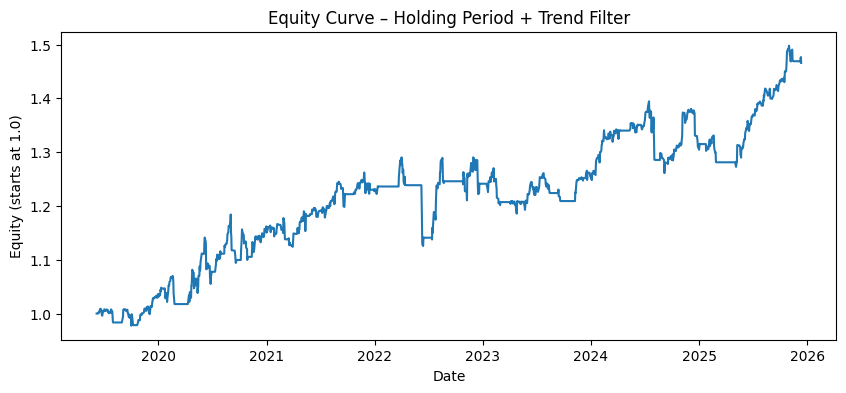

In [ ]:
# Plot the portfolio equity curve produced by the trend-filtered strategy
plt.figure(figsize=(10, 4))
plt.plot(daily["date"], daily["equity"])
plt.title("Equity Curve – Holding Period + Trend Filter")
plt.xlabel("Date")
plt.ylabel("Equity (starts at 1.0)")
plt.show()


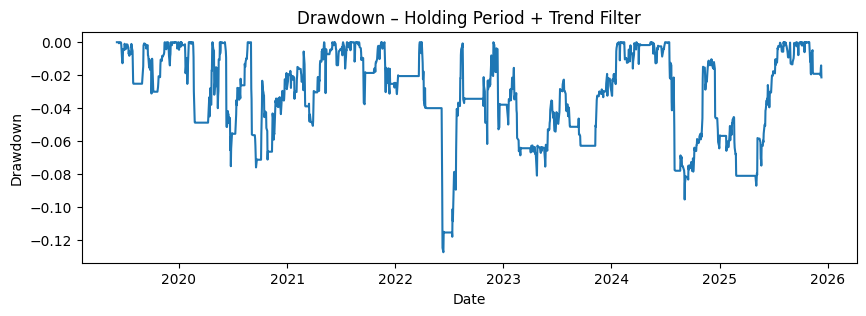

In [ ]:
# Compute drawdown versus running peak to visualize downside risk
daily["rolling_max"] = daily["equity"].cummax()
daily["drawdown"] = daily["equity"] / daily["rolling_max"] - 1

plt.figure(figsize=(10, 3))
plt.plot(daily["date"], daily["drawdown"])
plt.title("Drawdown – Holding Period + Trend Filter")
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.show()


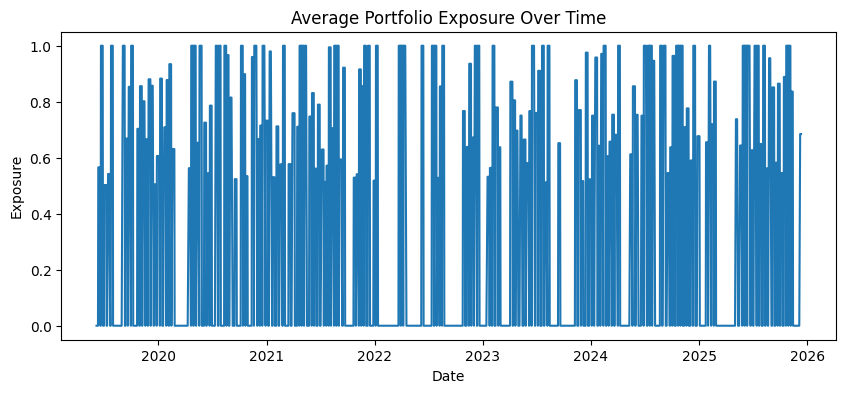

In [ ]:
# Average exposure across symbols to monitor portfolio crowding and allocation
exposure = (
    bt.groupby("date", as_index=False)["position"]
    .mean()
)

plt.figure(figsize=(10, 4))
plt.plot(exposure["date"], exposure["position"])
plt.title("Average Portfolio Exposure Over Time")
plt.xlabel("Date")
plt.ylabel("Exposure")
plt.show()


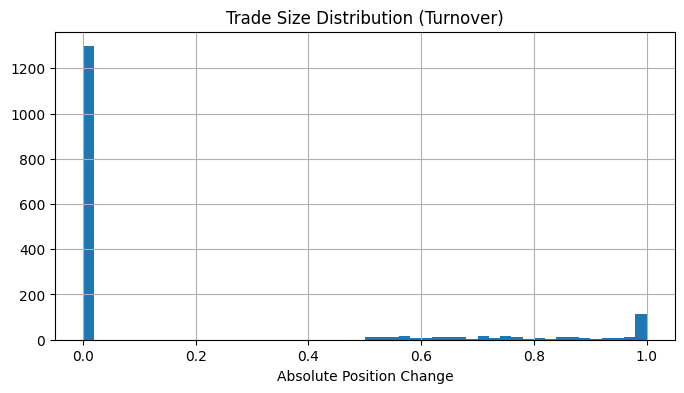

Average trade size: 0.16938138090834534


In [ ]:
# Compute turnover: previous position and absolute trade size per symbol
bt["prev_position"] = bt.groupby("symbol")["position"].shift(1).fillna(0.0)
bt["trade_size"] = (bt["position"] - bt["prev_position"]).abs()

plt.figure(figsize=(8, 4))
bt["trade_size"].hist(bins=50)
plt.title("Trade Size Distribution (Turnover)")
plt.xlabel("Absolute Position Change")
plt.show()

# Average trade size is a basic turnover metric
print("Average trade size:", bt["trade_size"].mean())


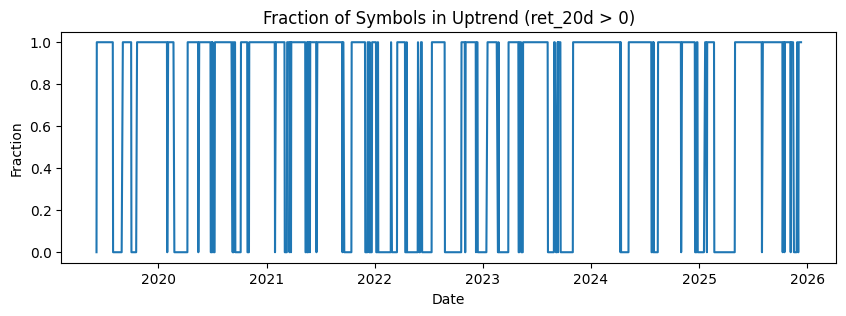

In [ ]:
# Fraction of symbols that meet the trend filter each day — shows regime activity
trend_activity = (
    bt.groupby("date", as_index=False)["trend_ok"]
    .mean()
)

plt.figure(figsize=(10, 3))
plt.plot(trend_activity["date"], trend_activity["trend_ok"])
plt.title("Fraction of Symbols in Uptrend (ret_20d > 0)")
plt.xlabel("Date")
plt.ylabel("Fraction")
plt.show()


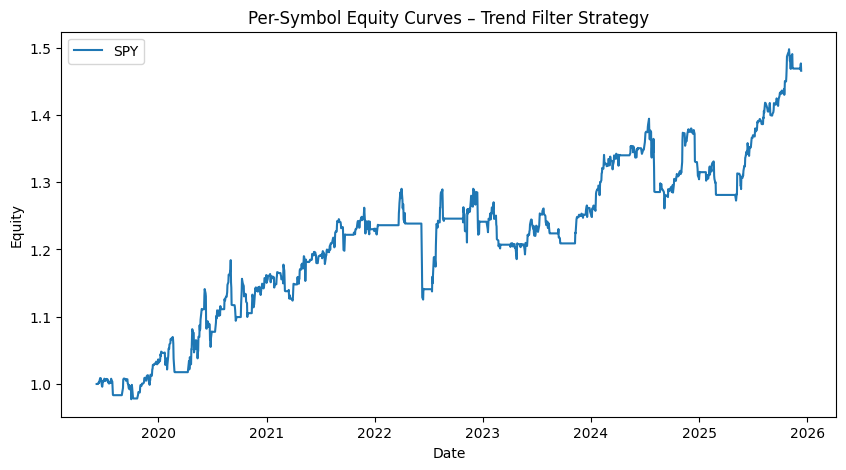

In [ ]:
# Per-symbol daily net returns and equity curves to inspect individual contributors
sym_daily = (
    bt.groupby(["symbol", "date"], as_index=False)["net_ret"]
    .sum()
)

sym_daily["cum_log_ret"] = sym_daily.groupby("symbol")["net_ret"].cumsum()
sym_daily["equity"] = np.exp(sym_daily["cum_log_ret"])

plt.figure(figsize=(10, 5))
for sym in sym_daily["symbol"].unique():
    sub = sym_daily[sym_daily["symbol"] == sym]
    plt.plot(sub["date"], sub["equity"], label=sym)

plt.title("Per-Symbol Equity Curves – Trend Filter Strategy")
plt.xlabel("Date")
plt.ylabel("Equity")
plt.legend()
plt.show()


In [ ]:
# Compute basic performance metrics: total return, mean/std daily returns, Sharpe, hit rate
total_return = daily["equity"].iloc[-1] - 1
avg_daily = daily["portfolio_ret"].mean()
vol_daily = daily["portfolio_ret"].std()
sharpe = (avg_daily / vol_daily) * np.sqrt(252) if vol_daily > 0 else np.nan
hit_rate = (daily["portfolio_ret"] > 0).mean()

print(f"Total return:     {total_return:.2%}")
print(f"Avg daily return: {avg_daily:.6e}")
print(f"Daily vol:        {vol_daily:.6e}")
print(f"Sharpe (approx):  {sharpe:.3f}")
print(f"Hit rate:         {hit_rate:.2%}")


Total return:     46.57%
Avg daily return: 2.331456e-04
Daily vol:        5.679147e-03
Sharpe (approx):  0.652
Hit rate:         29.02%
